In [4]:
#import libraries
import pennylane as qml
import pennylane.templates.embeddings as embedding
import torch
import torch.autograd
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
import math

from torchvision import transforms, utils

%matplotlib notebook
import matplotlib.pyplot as plt

#import pennylane.templates.layers as qmll
#from torch.autograd import Variable

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Looking into the Data, and preparing the preprocessing

In [6]:
# looking at the data
datas = pd.read_csv('breast-cancer-wisconsin-data\data.csv')
datas.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [7]:
datas = pd.read_csv('breast-cancer-wisconsin-data\data.csv')
#get the number of features
cols = datas.columns
print('there is ',len(cols), 'features')
#drop the useless features
datas = datas.drop(['Unnamed: 32', 'id'], axis = 1)
datas.head()

#changing the order of the columns
cols = datas.columns.tolist()
print(len(cols))
cols = cols[1:] + [cols[0]]
datas = datas[cols]
#changing the M and B by boolean
diag = { "M": 0, "B": 1}
datas["diagnosis"].replace(diag, inplace=True)
datas.head()

there is  33 features
31


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [10]:
#Accessing the labels
datas.iloc[:,-1].head()

0    0
1    0
2    0
3    0
4    0
Name: diagnosis, dtype: int64

# Dataloader, transform and preprocessing

In [11]:
# Dataloader

class GenericDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, transform=None, preprocessing =None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            preprocessing (callable, optional): Optional preprocessing to be applied
                on the complete dataset. can be label, pca, etc
        """
        
        #load the data
        self.data = pd.read_csv(csv_file)
        
        #apply the preprocessing, to make easier to work with
        if preprocessing :
            self.data = preprocessing(self.data)
        
        # shuffle the data
        self.data= self.data.sample(frac=1)
        
        #separate features from labels
        self.Xs = self.data.iloc[:,0:-1]
        self.labels = self.data.iloc[:,-1]
        
        #other attributes
        self.transform = transform
        self.nfeatures = len(self.Xs.iloc[0,:])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #print(type(idx))
        #convert the idx normal list, to make it compatible with random_split
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = torch.tensor(self.Xs.iloc[idx,:].as_matrix()).float() #take the features, locate the idx, to numpy, to tensor, to floattensor
        Y = torch.tensor(self.labels.iloc[idx]).long() #take the features, locate the idx, to numpy, to tensor, to longtensor
                                                       #remark: the long is for the nn.CrossEntropy
        #put it into a dictionnary (not sure to know why, but it s the official way)
        sample = {'X': X, 'label': Y}
        #apply the transform to the selected element
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def get_nfeatures(self,): #give the number of features after preprocessing and transform.
        sample = self[0]
        X = sample['X']
        return(X.shape[0])
        
            
            
            
    

In [12]:
class Polynomial_transform(object):
    
#     """extend the features to their polynomial compinastion, up to a specified degree.

#     Args:
#         degree of the polynomial extension
#     """

    def __init__(self, degree):
        self.degree = degree
        self.poly = PolynomialFeatures(self.degree) #scikit learn polynomial extension

    def __call__(self, sample):
        X, Y = sample['X'], sample['label']
        xsize = X.shape
        X = X.unsqueeze(dim=0)
        X = torch.tensor(self.poly.fit_transform(X)).float()
        X = X.squeeze()
        sample = {'X': X, 'label': Y}
        return sample
    
    
class Yeo_Johnson_transform(object):
    
    def __init__(self, standardize = False):
        self.standardize = standardize
        self.pt = PowerTransformer(method='yeo-johnson', standardize=self.standardize) #scikit learn Powertransform
                                            # the method 'box-cox' could also work but only with positive values

    def __call__(self, sample):
        X, Y = sample['X'], sample['label']
        xsize = X.shape
        X = X.unsqueeze(dim=0) #make it batch like
        X = torch.tensor(self.poly.fit_transform(X)).float()
        X = X.squeeze() #back to the sample real dim
        sample = {'X': X, 'label': Y}
        return sample
    

In [35]:
class Iris_binary_prep(object): #preprocessing for the Iris dataset
    def __init__(self,):
        super(Iris_binary_prep, self).__init__()
        
    def __call__(self, data): #data is in panda format
        data = data.replace('Iris-setosa',0)
        data = data.replace('Iris-virginica',1)
        data = data.replace('Iris-versicolor',2)
        data = data[data.iloc[:,-1] != 2]
        data = data.drop(columns="Id")
        data = pd.DataFrame(data.as_matrix(), columns=['SepalLengthCm'  ,'SepalWidthCm','PetalLengthCm','PetalWidthCm', 'Species'])
        return data
        
    
class BC_binary_prep(object): #preprocessing for the BC dataset
    def __init__(self,):
        super(BC_binary_prep, self).__init__()
        
    def __call__(self, data): #data is in panda format
        data = data.drop(['Unnamed: 32', 'id'], axis = 1)
        cols = data.columns.tolist()
        cols = cols[1:] + [cols[0]]
        data = data[cols]
#         data['diagnosis'].loc[data['diagnosis'] == 'M'] = 0
#         data['diagnosis'].loc[data['diagnosis'] == 'B'] = 1
        diag = { "M": 0, "B": 1}
        data["diagnosis"].replace(diag, inplace=True)
        return data
        
    
class Yeo_Johnson_prep(object): #Yeo Johnson transformation but applied to the whole dataset,
                                #enables to compute reasonable mean and std for the case of standardize==True
    def __init__(self, standardize = False):
        super(Yeo_Johnson_prep, self).__init__()
        self.standardize = standardize
        self.pt = PowerTransformer(method= 'yeo-johnson', standardize=self.standardize)#scikit learn Powertransform
                                            # the method 'yeo-johnson','box-cox' could also work but only with positive values

        
    def __call__(self, data): #data is in panda format, after the first preprocessing has been applied
        x = data.iloc[:,0:-1] 
        data.iloc[:,0:-1] = self.pt.fit_transform(x)
        return data
    
    

    
class Polynomial_prep(object): #Polynomial extension but applied once for all in the dataset (memory vs computation)

    def __init__(self, degree):
        self.degree = degree
        self.poly = PolynomialFeatures(self.degree)

    def __call__(self, data):
        x = data.iloc[:,0:-1]
        labels = data.iloc[:,-1]
        x = pd.DataFrame(selfpoly.fit_transform(x))
        data = pd.concat([x,labels], axis=1)
        return data
    
    
    
class PCA_prep(object): #apply a pca 
    
    def __init__(self, n_components):
        
        self.n_components = n_components
        self.pca = PCA(self.n_components)

    def __call__(self, data):
        datar = np.array(data)
        X = datar[:,0:-1]
        y = labels = np.expand_dims(datar[:,-1],1)
        pca = PCA(n_components=2)
        pca.fit(X)
        X = pca.transform(X)
        data = pd.DataFrame(np.concatenate((X,y), axis=1))
        return data
    

    
class Kernel_PCA_prep(object): #apply a kernel pca, default is gaussian
    
    def __init__(self, n_components, kernel = 'rbf'):
        self.kernel = kernel
        self.n_components = n_components
        self.kpca = KernelPCA(self.n_components)

    def __call__(self, data):
        x = data.iloc[:,0:-1]
        labels = data.iloc[:,-1]
        x = pd.DataFrame(self.kpca.fit_transform(x))
        data = pd.concat([x,labels], axis=1)
        return data

# Testing the data preparation

before
     radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  compactness_mean  concavity_mean  concave points_mean  symmetry_mean  fractal_dimension_mean  radius_se  texture_se  perimeter_se  area_se  smoothness_se  compactness_se  concavity_se  concave points_se  symmetry_se  fractal_dimension_se  radius_worst  texture_worst  perimeter_worst  area_worst  smoothness_worst  compactness_worst  concavity_worst  concave points_worst  symmetry_worst  fractal_dimension_worst  diagnosis
269        10.71         20.39           69.50      344.9          0.10820            0.1289        0.084480             0.028670         0.1668                 0.06862     0.3198      1.4890         2.230    20.74       0.008902        0.047850      0.073390           0.017450      0.02728              0.007610         11.69          25.21            76.51       410.4           0.13350            0.25500         0.253400               0.08600          0.2605                  0.08701     

<IPython.core.display.Javascript object>


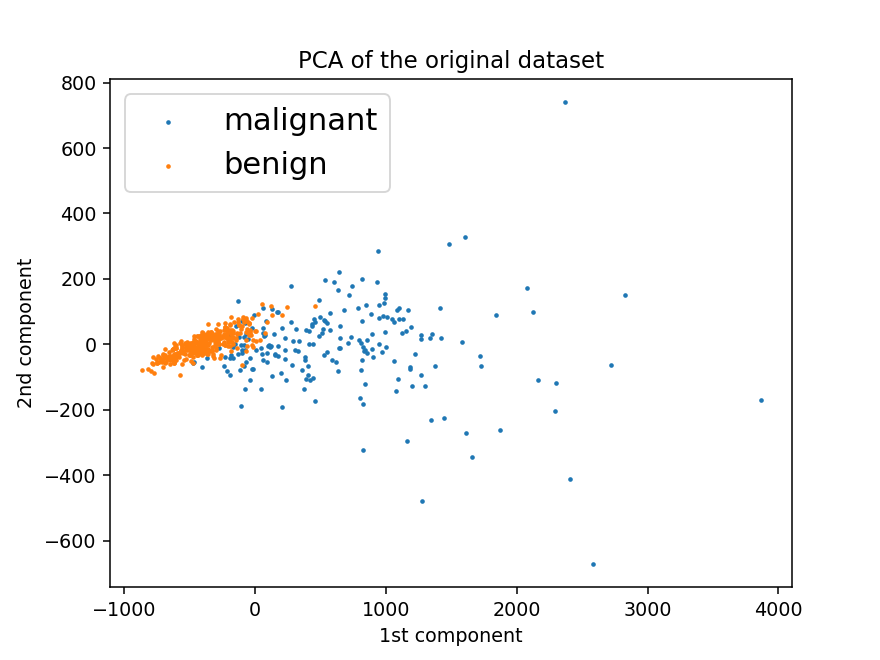

(212, 2) (357, 2)


In [36]:
# TEST PCA
from IPython.display import display
import numpy as np
csv_file = 'breast-cancer-wisconsin-data\data.csv'
data = pd.read_csv(csv_file)
datar= data.sample(frac=1)
prep = BC_binary_prep()
prepca = PCA_prep(2)

datar = prep(datar)
print('before')
print(datar.head())


datar = prepca(datar)

print('after')
print(datar.head())

datar = np.array(datar)

X = datar[:,0:-1]
y = datar[:,-1]

fig, ax = plt.subplots(nrows=1, ncols=1)

l0 = X[y==0]
l1 = X[y==1]

print(l0.shape, l1.shape)
ax.scatter(l0[:,0],l0[:,1],s=2, label = 'malignant')
ax.scatter(l1[:,0],l1[:,1],s=2, label = 'benign')
ax.set_title('PCA of the original dataset')
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.legend(fontsize=16)



In [37]:
csv_file = 'breast-cancer-wisconsin-data\data.csv'
data = pd.read_csv(csv_file)
prep = BC_binary_prep()

prepyj = Yeo_Johnson_prep(True) #Bug Yeo johnson does not work log divide by zero pb... no idea...
prepkrbf = Kernel_PCA_prep(10)
composed = transforms.Compose([prep,prepkrbf])
data = composed(data)
data.head()

,0,1,2,3,4,5,6,7,8,9,diagnosis
0,1160.142574,-293.917544,48.578398,-8.711975,32.000486,1.265415,0.931337,0.148167,0.745463,0.589359,0
1,1269.122443,15.630182,-35.394534,17.861283,-4.334874,-0.225872,-0.046037,0.200804,-0.485828,-0.084035,0
2,995.793889,39.156743,-1.709753,4.199340,-0.466529,-2.652811,-0.779745,-0.274026,-0.173874,-0.186994,0
3,-407.180803,-67.380320,8.672848,-11.759867,7.115461,1.299436,-1.267304,-0.060555,-0.330639,-0.144155,0
4,930.341180,189.340742,1.374801,8.499183,7.613289,1.021160,-0.335522,0.289109,0.036087,-0.138502,0


In [38]:
#testing the get_nfeatures()
csv_file = 'breast-cancer-wisconsin-data\data.csv'
prep = BC_binary_prep()
dataset = GenericDataset(csv_file,transform = None, preprocessing = prep)
dataset.get_nfeatures()

C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


30

# Construction of the End To End model

In [39]:
#making an highly entangling layer

def stronglayer(slparam, n_wires, r=1):
    slparam = math.pi * slparam

    qml.RX(slparam[0,0], wires = 0)
    qml.RY(slparam[1,0], wires = 0)
    qml.RZ(slparam[2,0], wires = 0)
    for i in range(1,n_wires):

        qml.RX(slparam[0,i], wires = i)
        qml.RY(slparam[1,i], wires = i)
        qml.RZ(slparam[2,i], wires = i)
        qml.CNOT(wires=[i, i-1])
    qml.CNOT(wires=[0, n_wires-1])

In [40]:
# This is a refined version of the stronglayer, where the  entanglement is also learned. 
# Here slparam has one more line, containing the angles of the Xrotation

def stronglayerCRX(slparam, n_wires, r=1):
    slparam = math.pi * slparam

    qml.RX(slparam[0,0], wires = 0)
    qml.RY(slparam[1,0], wires = 0)
    qml.RZ(slparam[2,0], wires = 0)
    for i in range(1,n_wires):

        qml.RX(slparam[0,i], wires = i)
        qml.RY(slparam[1,i], wires = i)
        qml.RZ(slparam[2,i], wires = i)
        qml.CRX(phi =slparam[3,i],wires=[i, i-1])
    qml.CRX(phi =slparam[3,0], wires=[0, n_wires-1])

In [43]:
# QA first try of a complex Classical Encoder that will go before the Quantum Encoder

class CE(torch.nn.Module):
    def __init__(self,):
        super(CE, self).__init__()
        self.l1 = torch.nn.Linear(30,16)
        self.l2 = torch.nn.Linear(16,4)
        
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        out1 = self.sigmoid(self.l1(x)) 
        #y_pred = self.sigmoid(self.l2(out1)) - 0.5
        y_pred = self.tanh(self.l2(out1))
        return y_pred
    
    
test = CE()


In [45]:
#One layer Calssical encoder
class CE_1l(torch.nn.Module):
    def __init__(self,out_dim = 4):
        super(CE_1l, self).__init__()
        self.out_dim = out_dim
        self.l1 = torch.nn.Linear(30,out_dim)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        #out1 = self.sigmoid(self.l1(x)) - 0.5
        out1 = self.tanh(self.l1(x)) - 0.5
        return out1
    

In [46]:
#Only normalyzing the weight, no parameters are learned on this CE
class CE_id(torch.nn.Module):
    def __init__(self):
        super(CE_id, self).__init__()
        #self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        #out1 = self.sigmoid(x) - 0.5
        out1 = self.tanh(x)
        return out1

In [47]:
class HQC(nn.Module):
    def __init__(self,device, n_wires, CE, n_qfeatures, n_QClayers):
        super(HQC, self).__init__()
        self.device = device
        self.n_wires =n_wires
        self.mode = torch.tensor(1, dtype = torch.uint8)
        self.n_qfeatures = n_qfeatures #dimension of the output of CE
        self.n_QClayers = n_QClayers #numbers of layers in the Quantum classifier
        self.n_QElayers = math.ceil(self.n_qfeatures/n_wires) #number of layer necessary to encode my data
        print('self.n_QElayers', self.n_QElayers)
        self.to_pad = self.n_QElayers*n_wires - self.n_qfeatures #number of layer necessary to encode my data
        print('self.to_pad',self.to_pad)
        #assert self.to_pad == 0,"CE exit dim is not a multiple of n_wires"
        #CE
        self.CE = CE # before I was using nn.Sequential(*CE_layers), may still be a good idea
        #QE
        self.QE_optvar = torch.nn.Parameter(torch.randn((self.n_QElayers, 2, n_wires), requires_grad =True))
        #QC
        self.QC_optvar = torch.nn.Parameter(torch.randn((self.n_QClayers, 3, n_wires), requires_grad =True))
        
        
    def trainmode_(self,):
        self.mode = torch.tensor(1, dtype = torch.uint8)
        
    def evalmode_(self,):
        self.mode = torch.tensor(0, dtype = torch.uint8)
        
    def forward(self, x):

        #CE        
        #x = x.view(-1, self.num_flat_features(x)) #usefull when batched!
        x = self.CE(x)
        #QE 

        x =F.pad(x, (0,self.to_pad))
        x = x.view((self.n_QElayers, 1, self.n_wires)) #reshape so that it can be concat with the learnable parameters
        QE_param = torch.cat((x,self.QE_optvar,), dim = 1) # concat them to make them fit in stronglayer
        # if we are in training_mode
        if(self.mode):
            #QE 
            @qml.qnode(self.device, interface='torch')
            def circuit(x,QE_param,QC_optvar):
                #QE 
                for j in range(self.n_QElayers):
                    QE_layparam = QE_param[j,:,:]
                    stronglayer(QE_layparam,r=1, n_wires = self.n_wires)
                for i in range(self.n_QClayers):
                    QC_layparam = QC_optvar[i,:,:]
                    stronglayer(QC_layparam,r=1, n_wires = self.n_wires)
                return qml.expval.PauliZ(0)
            
        else:
            @qml.qnode(self.device, interface='torch')
            def circuit(x,QE_param,QC_optvar):
                #QE 
                for j in range(self.n_QElayers):
                    QE_layparam = QE_param[j,:,:]
                    stronglayer(QE_layparam,r=1, n_wires = self.n_wires)
                return qml.expval.PauliZ(0)

        #QC
        out = 0.5*(1+(circuit(x,QE_param,self.QC_optvar)))
        out = out.unsqueeze(0)

        return torch.cat((out,1-out,))

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        print('numflat',num_features)
        return num_features

# Training

In [52]:
dev = qml.device('default.qubit', wires=4)
model = HQC(dev,4, test, 30, 2) 

#checking that all the parameters I want to optimize are there
print(model.parameters())
for name, param in model.named_parameters():
    print(name,param)

self.n_QElayers 8
self.to_pad 2
<generator object Module.parameters at 0x000001DEAC9A4308>
QE_optvar Parameter containing:
tensor([[[ 0.0684, -1.3388, -0.6910,  0.3011],
         [-0.7879, -0.2644, -1.2225, -1.0995]],

        [[ 0.5991,  0.3049,  0.1435,  0.2316],
         [-0.2126, -1.5549,  0.1387,  0.3603]],

        [[ 0.9165,  0.9961,  0.5533,  0.9340],
         [-1.1055, -0.7330, -0.2355,  0.0419]],

        [[ 0.3008,  0.2475, -0.5319,  1.0321],
         [-0.2134,  0.3739,  1.7938,  0.7635]],

        [[ 0.7158, -0.7689,  0.4055, -1.7033],
         [ 1.6627, -0.6433,  0.2599,  1.3605]],

        [[ 1.1133, -1.9712,  0.2261, -1.3760],
         [ 1.7180,  1.1042, -2.1708, -1.7248]],

        [[ 0.1247, -0.3318, -0.4623, -0.9419],
         [ 1.6787,  1.8264, -1.5566, -1.0618]],

        [[ 2.0962,  0.4943,  0.1387, -0.3484],
         [ 0.9041,  0.0528,  0.7495,  0.1668]]], requires_grad=True)
QC_optvar Parameter containing:
tensor([[[-1.1612,  1.3212, -1.7095,  1.1024],
         [

In [54]:
#Dataset and splitting 
csv_file = 'breast-cancer-wisconsin-data\data.csv'
prep = BC_binary_prep()
poly = Polynomial_prep(degree = 2)
full_dataset = GenericDataset(csv_file, transform=None, preprocessing = prep)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])


#showing the number of feature after preprocessing
full_dataset.get_nfeatures()


C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


30

In [55]:
%matplotlib notebook
import matplotlib.pyplot as plt

#Model
dev = qml.device('default.qubit', wires=5)
CE_model = CE_id()
model = HQC(dev, 4, CE_model, 30, 3) #device, n_wires, CE, n_qfeatures, n_QClayers
#TRAIN
n_epoch = 5
postprocessing = nn.LogSoftmax()
loss_fn = torch.nn.CrossEntropyLoss() #nn.NLLLoss()

        

        
def train(model,train_dataset,test_dataset,loss_fn,n_epoch=5):
    model.trainmode_()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    valid_losses = []
    valid_acc = []
    train_losses = []
    train_loss_store = torch.zeros(1)
    idx = []
    for e in range(n_epoch):
        print('n_epoch',e)
        for i in range(len(train_dataset)):
            print('train_data i',i)
            
            #eval
            if (i%100 == 0):
                idx +=[i]
                score = torch.zeros(1)
                valid_loss_store = torch.zeros(1)
                
                with torch.no_grad():
                    for j in range(len(test_dataset)):
                        #print('evalmode', j)
                        sample = test_dataset[j]
                        X, label = sample['X'], sample['label']
                        output = model(X)
                        output = torch.unsqueeze(output,0)
                        label = torch.unsqueeze(label,0)
                        #output = torch.log(output)#postprocessing(output)
                        loss = loss_fn(output, label)
                        valid_loss_store += loss
                        
                        _, predicted = torch.max(output.data, 1)
                        print('predandlab', predicted, label)
                        score += predicted.eq(label).float()
                score = score/len(test_dataset)
                print('acc', score)
                valid_acc += [score.item()]
                valid_loss_store = valid_loss_store/len(test_dataset)
                print('valid_loss_store',valid_loss_store)
                valid_losses += [valid_loss_store.item()]
                train_loss_store = train_loss_store/20
                print('train_loss_store',train_loss_store)
                train_losses += [train_loss_store.item()]
                train_loss_store = torch.zeros(1)
                    


                    
            sample = train_dataset[i]
            X, label = sample['X'], sample['label']
            #print(label)

            optimizer.zero_grad()
            output = model(X)
            #print('out req_grad', output.requires_grad)
            
            
            #artificially adding the batch dimention to make it compatible with the loss function
            output = torch.unsqueeze(output,0)
            label = torch.unsqueeze(label,0)
            #output = torch.log(output)#postprocessing(output)
            
            loss = loss_fn(output, label)
            #loss = - label*torch.log(output) - (1-label)*torch.log(1-output)
            train_loss_store += loss
            
            #print('loss', loss)
            loss.backward()
#             for name, param in model.named_parameters():
#                 #print(param)
#                 print(i,name,'gradient odg',param.grad.data.sum())
            optimizer.step()
    return idx, train_losses, valid_losses, valid_acc
            
            

    
idx, train_losses, valid_losses, valid_acc = train(model,train_dataset, test_dataset,loss_fn)


C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


self.n_QElayers 8
self.to_pad 2
n_epoch 0
train_data i 0
predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([0]) tensor([1])
predandlab tensor([0]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([0])
predandlab tensor([0]) tensor([1])
predandlab tensor([0]) tensor([0])
predandlab tensor([0]) tensor([0])
predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([0]) tensor([0])
predandlab tensor([0]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([0]) tensor([0])
predandlab tensor([1]) tensor([1])
predandlab tensor([0]) tensor([0])
predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([0]) tensor([0])
predandlab tensor([0]) tensor([1])
predandlab tensor([0]) tensor([0])
predandlab tensor([0]) tensor([0])
predandlab tensor([0]) tensor([0]

KeyboardInterrupt: 

In [ ]:
print(idx)

In [ ]:
print(valid_acc)

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(valid_losses)

In [ ]:
plt.plot(valid_acc)

# Comparaison avec Amplitude Encoding

In [ ]:
class AEQC(nn.Module):
    def __init__(self,device, n_wires, CE, n_qfeatures, n_QClayers):
        super(AEQC, self).__init__()
        self.device = device
        self.n_wires =n_wires
        self.mode = torch.tensor(1, dtype = torch.uint8)
        self.n_qfeatures = n_qfeatures #dimension of the output of CE
        self.n_QClayers = n_QClayers
        self.to_pad = 2**n_wires - n_qfeatures
        #CE
        self.CE = CE #nn.Sequential(*CE_layers)
        #QE
        self.wires_to_encode = list(range(0,n_wires))
        #QC
        self.QC_optvar = torch.nn.Parameter(torch.randn((self.n_QClayers, 3, n_wires), requires_grad =True))
        
    def forward(self, x):
        #CE        
        #x = x.view(-1, self.num_flat_features(x)) #usefull when batched!
        x = self.CE(x)
        #QE 
        #x = torch.unsqueeze(x, dim=0)
        
        x =F.pad(x, (0,self.to_pad))

        @qml.qnode(self.device, interface='torch')
        def circuit(x,QC_optvar):
            #QE 
            embedding.AmplitudeEmbedding(x, self.wires_to_encode)
            #QCyu
            for i in range(self.n_QClayers):
                QC_layparam = QC_optvar[i,:,:]
                stronglayer(QC_layparam,r=1, n_wires = self.n_wires)
            return qml.expval.PauliZ(0)


        #QC
        out = 0.5*(1+(circuit(x,self.QC_optvar)))
        out = out.unsqueeze(0)
#         print(type(out),out,out.shape)
#         print('req grad dans le forward', out.requires_grad)
        return torch.cat((out,1-out,))#0.5*(1+(circuit(x,QE_param,self.QC_optvar)))

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        print('numflat',num_features)
        return num_features

In [ ]:
#Dataset and splitting 
csv_file = 'breast-cancer-wisconsin-data\data.csv'
prep = BC_binary_prep()
poly = Polynomial_prep(degree = 2)
full_dataset = GenericDataset(csv_file, transform=None, preprocessing = prep)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

full_dataset.get_nfeatures()

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

#Model
n_wires = 3
dev = qml.device('default.qubit', wires=n_wires)
CE_model = CE_id()
model = AEQC(dev, n_wires, CE_model, 30, 3) #device, n_wires, CE, n_qfeatures, n_QClayers
#TRAIN
n_epoch = 5
postprocessing = nn.LogSoftmax()
loss_fn = torch.nn.CrossEntropyLoss() #nn.NLLLoss()

    
        
def train(model,train_dataset,test_dataset,loss_fn,n_epoch=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    valid_losses = []
    valid_acc = []
    train_losses = []
    train_loss_store = torch.zeros(1)
    idx = []
    for e in range(n_epoch):
        print('n_epoch',e)
        for i in range(len(train_dataset)):
            print('train_data i',i)
            
            #eval
            if (i%100 == 0):
                idx +=[i]
                score = torch.zeros(1)
                valid_loss_store = torch.zeros(1)
                
                with torch.no_grad():
                    for j in range(len(test_dataset)):
                        #print('evalmode', j)
                        sample = test_dataset[j]
                        X, label = sample['X'], sample['label']
                        output = model(X)
                        output = torch.unsqueeze(output,0)
                        label = torch.unsqueeze(label,0)
                       
                        loss = loss_fn(output, label)
                        valid_loss_store += loss
                        
                        _, predicted = torch.max(output.data, 1)
                        print('predandlab', predicted, label)
                        score += predicted.eq(label).float()
                score = score/len(test_dataset)
                print('acc', score)
                valid_acc += [score.item()]
                valid_loss_store = valid_loss_store/len(test_dataset)
                print('valid_loss_store',valid_loss_store)
                valid_losses += [valid_loss_store.item()]
                train_loss_store = train_loss_store/20
                print('train_loss_store',train_loss_store)
                train_losses += [train_loss_store.item()]
                train_loss_store = torch.zeros(1)
                    


                    
            sample = train_dataset[i]
            X, label = sample['X'], sample['label']
            #print(label)

            optimizer.zero_grad()
            output = model(X)
            #print('out req_grad', output.requires_grad)
            
            
            #artificially adding the batch dimention to make it compatible with the loss function
            output = torch.unsqueeze(output,0)
            label = torch.unsqueeze(label,0)
            loss = loss_fn(output, label)
            train_loss_store += loss

            loss.backward()
            optimizer.step()
    return idx, train_losses, valid_losses, valid_acc
            
            

    
idx, train_losses, valid_losses, valid_acc = train(model,train_dataset, test_dataset,loss_fn)
